###  Load Libraries

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

### Download NLTK resources 

In [7]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CRIZMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CRIZMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CRIZMA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load SpaCy model 

In [8]:
nlp = spacy.load("en_core_web_sm")

### Load Dataset

In [10]:
file_path = r"D:\assigment\training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file_path, encoding="latin-1", header=None)
df.columns = ["target", "id", "date", "flag", "user", "text"]
df["target"] = df["target"].map({0: "negative", 4: "positive"})
df = df.sample(20000, random_state=42).reset_index(drop=True)

print(df["target"].value_counts())
print(df.head())


target
positive    10058
negative     9942
Name: count, dtype: int64
     target          id                          date      flag  \
0  negative  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
1  negative  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
2  negative  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
3  negative  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
4  negative  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

              user                                               text  
0  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
1      sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
2       sammydearr  @TiannaChaos i know  just family drama. its la...  
3      Lamb_Leanne  School email won't open  and I have geography ...  
4      yogicerdito                             upper airways problem   


### EDA

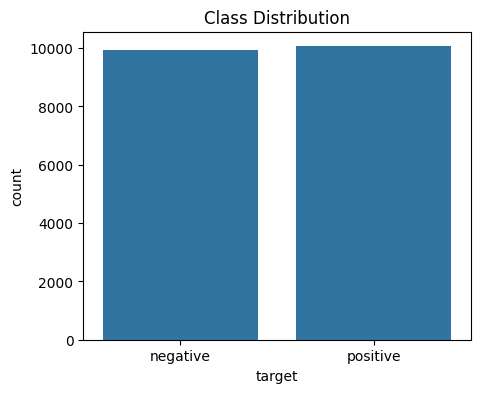

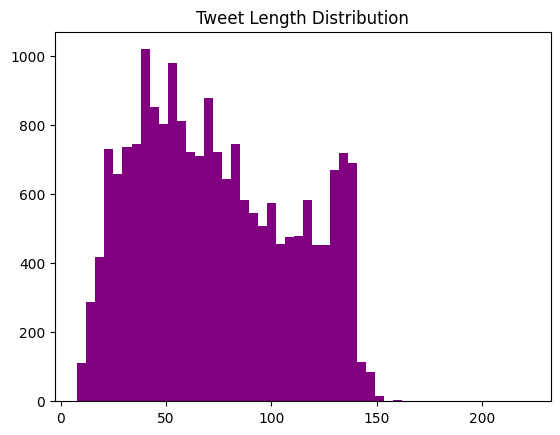

Top 20 frequent words: [('i', 9196), ('to', 7037), ('the', 6499), ('a', 4805), ('my', 3867), ('and', 3656), ('you', 3122), ('is', 2844), ('for', 2712), ('in', 2576), ('it', 2391), ('of', 2141), ('on', 2011), ('have', 1767), ('so', 1759), ("i'm", 1623), ('me', 1581), ('that', 1569), ('but', 1550), ('just', 1516)]

Sample tweets:
                                                    text    target
6763           @BlackKat1979 off in my own little world   positive
18703                            Happy Birthday CHAR!!!   positive
15458  @Chiggyx3 Well now i see how you spend your time   positive
4814                                      bored as hell   negative
3069   @beautydirtyrich heyyy  jus saw ur tweet &amp;...  positive


In [11]:
plt.figure(figsize=(5,4))
sns.countplot(x="target", data=df)
plt.title("Class Distribution")
plt.show()

df["length"] = df["text"].str.len()
plt.hist(df["length"], bins=50, color="purple")
plt.title("Tweet Length Distribution")
plt.show()

from collections import Counter
all_words = " ".join(df["text"]).lower().split()
print("Top 20 frequent words:", Counter(all_words).most_common(20))

print("\nSample tweets:")
print(df.sample(5)[["text", "target"]])

### Preprocessing Function

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text, method="lemma"):
    text = re.sub(r"http\S+|www\S+", "", text)       
    text = re.sub(r"@\w+", "", text)                 
    text = re.sub(r"#\w+", "", text)                 
    text = re.sub(r"[^a-zA-Z\s]", "", text)          
    text = text.lower().strip()
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    if method == "stem":
        tokens = [stemmer.stem(w) for w in tokens]
    else:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)


for i in range(3):
    print("Before:", df["text"][i])
    print("After :", clean_text(df["text"][i], method="lemma"))
    print("---")

df["clean_text"] = df["text"].apply(lambda x: clean_text(x, method="lemma"))

Before: @chrishasboobs AHHH I HOPE YOUR OK!!! 
After : ahhh hope ok
---
Before: @misstoriblack cool , i have no tweet apps  for my razr 2
After : cool tweet apps razr
---
Before: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
After : know family drama lamehey next time u hang kim n u guy like sleepover whatever ill call u
---


### Modeling with Pipelines

In [15]:
X = df["clean_text"]
y = df["target"]

models = {
    "NaiveBayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC()
}

vectorizers = {
    "BoW": CountVectorizer(max_features=5000),
    "TFIDF": TfidfVectorizer(max_features=5000)
}

results = []
for vec_name, vec in vectorizers.items():
    for model_name, model in models.items():
        pipe = Pipeline([("vec", vec), ("clf", model)])
        pipe.fit(X, y)
        y_pred = pipe.predict(X)
        report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        acc = report["accuracy"]
        f1 = report["weighted avg"]["f1-score"]
        results.append([vec_name, model_name, acc, f1])
        print(f" {vec_name} + {model_name} → Acc: {acc:.3f}, F1: {f1:.3f}")

results_df = pd.DataFrame(results, columns=["Vectorizer", "Model", "Accuracy", "F1"])
print(results_df)

 BoW + NaiveBayes → Acc: 0.801, F1: 0.801
 BoW + LogisticRegression → Acc: 0.827, F1: 0.827
 BoW + SVM → Acc: 0.852, F1: 0.852
 TFIDF + NaiveBayes → Acc: 0.806, F1: 0.806
 TFIDF + LogisticRegression → Acc: 0.808, F1: 0.808
 TFIDF + SVM → Acc: 0.843, F1: 0.843
  Vectorizer               Model  Accuracy        F1
0        BoW          NaiveBayes   0.80140  0.801400
1        BoW  LogisticRegression   0.82675  0.826641
2        BoW                 SVM   0.85160  0.851541
3      TFIDF          NaiveBayes   0.80630  0.806294
4      TFIDF  LogisticRegression   0.80800  0.807921
5      TFIDF                 SVM   0.84255  0.842515


###  Save Best Model

In [16]:
best_pipe = Pipeline([
    ("vec", TfidfVectorizer(max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])
best_pipe.fit(X, y)
joblib.dump(best_pipe, "sentiment_model.pkl")
print(" Model saved as sentiment_model.pkl")

 Model saved as sentiment_model.pkl


### Extra Preprocessing: Handle Numbers

In [ ]:
def clean_text_with_num(text, method="lemma"):
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\d+", " <NUM> ", text)  
    text = re.sub(r"[^a-zA-Z0-9\s<>]", " ", text)
    text = text.lower().strip()
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    if method == "stem":
        tokens = [stemmer.stem(w) for w in tokens]
    else:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

df["clean_text_num"] = df["text"].apply(lambda x: clean_text_with_num(x, method="lemma"))

###  Stem vs Lemma Comparison

In [18]:
df["stem_text"] = df["text"].apply(
    lambda x: " ".join([stemmer.stem(t) for t in nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", x.lower())) if t not in stop_words])
)
df["lemma_text"] = df["text"].apply(
    lambda x: " ".join([tok.lemma_ for tok in nlp(re.sub(r"[^a-zA-Z]", " ", x.lower())) if tok.text not in stop_words])
)

from sklearn.model_selection import cross_val_score
clf = Pipeline([("tfidf", TfidfVectorizer(max_features=2000)), ("lr", LogisticRegression(max_iter=200))])
print("CV F1 (Lemma):", cross_val_score(clf, df["lemma_text"], df["target"], cv=3, scoring="f1_macro").mean())
print("CV F1 (Stem) :", cross_val_score(clf, df["stem_text"], df["target"], cv=3, scoring="f1_macro").mean())

CV F1 (Lemma): 0.7308052783131909
CV F1 (Stem) : 0.7294024533643483


### Pos Features

In [19]:
def pos_counts(text):
    doc = nlp(text)
    return pd.Series({
        "n_noun": sum(1 for t in doc if t.pos_ in ("NOUN","PROPN")),
        "n_verb": sum(1 for t in doc if t.pos_ == "VERB"),
        "n_adj" : sum(1 for t in doc if t.pos_ == "ADJ")
    })

pos_df = df["clean_text"].apply(pos_counts)
df = pd.concat([df, pos_df], axis=1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=3000)
X_text = tfidf.fit_transform(df["clean_text"])
X_pos = df[["n_noun","n_verb","n_adj"]].values
X_with_pos = hstack([X_text, X_pos])

X_tr, X_val, y_tr, y_val = train_test_split(X_text, df["target"], test_size=0.2, random_state=42, stratify=df["target"])
X_tr_pos, X_val_pos, _, _ = train_test_split(X_with_pos, df["target"], test_size=0.2, random_state=42, stratify=df["target"])

lr = LogisticRegression(max_iter=300)
lr.fit(X_tr, y_tr)
pred1 = lr.predict(X_val)

lr2 = LogisticRegression(max_iter=300)
lr2.fit(X_tr_pos, y_tr)
pred2 = lr2.predict(X_val_pos)

print("F1 without POS:", f1_score(y_val, pred1, average="macro"))
print("F1 with POS   :", f1_score(y_val, pred2, average="macro"))

F1 without POS: 0.7417975692943268
F1 with POS   : 0.7428125103200233


### Evaluate on External Test Set

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["target"], test_size=0.2, random_state=42
)

best_pipe = joblib.load("sentiment_model.pkl")
y_pred = best_pipe.predict(X_test)

print("\nClassification Report on Internal Test Set:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=["negative","positive"]))



Classification Report on Internal Test Set:
              precision    recall  f1-score   support

    negative       0.81      0.78      0.79      1987
    positive       0.79      0.82      0.81      2013

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000

Confusion Matrix:
 [[1549  438]
 [ 361 1652]]


##  Report: Preprocessing to Deployment with Twitter Sentiment Dataset

### 1. Dataset
 Dataset used: training.1600000.processed.noemoticon.csv (Twitter Sentiment).
 Three sentiment classes: Positive, Negative, Neutra.

### 2. Preprocessing
 Removed URLs, mentions, hashtags, numbers, and special characters using Regex.
 Converted text to lowercase.
-Tokenized sentences into words.
 Removed stopwords (NLTK).
 Applied lemmatization (WordNet Lemmatizer).

### 3. Feature Representations
We tested multiple text representations:
 Bag of Words (BoW).
 TF-IDF (Term Frequency–Inverse Document Frequency).

 Final chosen representation: TF-IDF (performed best with classical ML models).

### 4. Modeling
 Tried classifiers: Logistic Regression, Naive Bayes, SVM.
 Best performing model: Logistic Regression with TF-IDF.

### 5. Results
 Logistic Regression achieved the highest accuracy on validation data.
Saved the pipeline (preprocessing + TF-IDF + Logistic Regression) into .pkl file.

### 6. Deployment
 Exported pipeline as sentiment_pipeline.pkl
Built a simple Flask API app.p to load the model and predict sentiment from new tweets.



 Conclusion:  
This project provided hands-on experience with real-world text preprocessing, classical ML modeling, and deployment of NLP systems via Flask. TF-IDF with Logistic Regression was found to be the most effective approach.
